# Segmentación de Lunares usando UNet


* Código de [Hae Yong Kim](http://www.lps.usp.br/hae/apostila/segment-ead.pdf) adaptado por Gabriel Garib y Domingo Mery

* Ronneberger, O., Fischer, P., & Brox, T. (2015, October). [U-net: Convolutional networks for biomedical image segmentation](https://arxiv.org/abs/1505.04597). In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

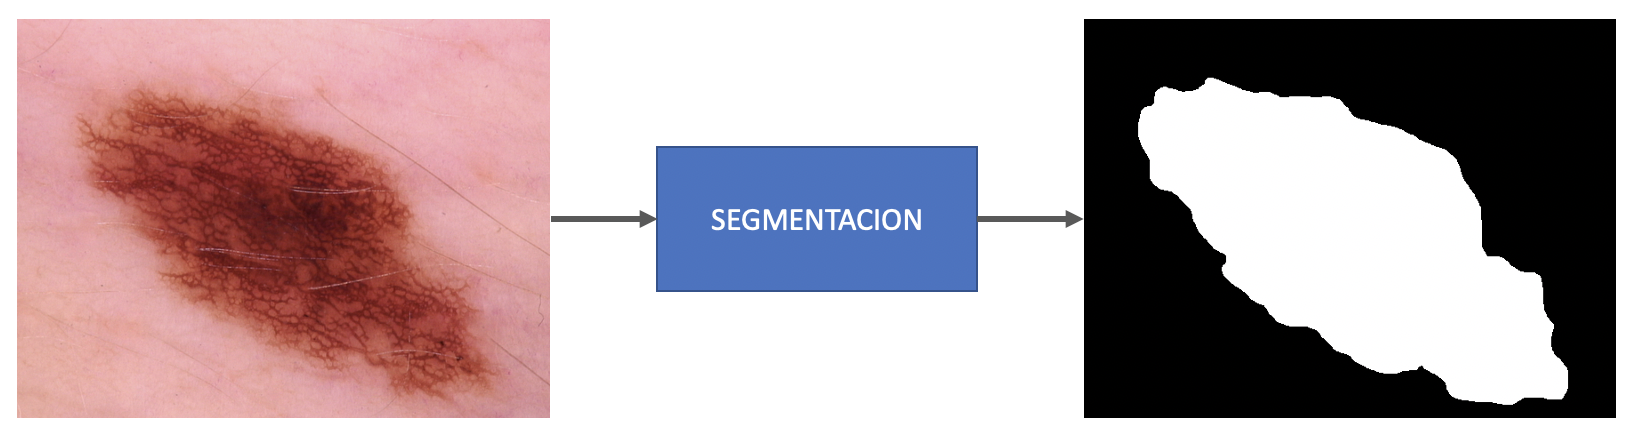

# Descarga de datos

Se descarga las imágenes a color en la carpeta `skin/color` y la segmentación manual en la carpeta `skin/seg`.

In [ ]:
!wget https://www.dropbox.com/s/dmvouv8oi9afnzi/skin_segmentation.zip
!unzip -qq skin_segmentation.zip

--2022-10-19 18:44:49--  https://www.dropbox.com/s/dmvouv8oi9afnzi/skin_segmentation.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dmvouv8oi9afnzi/skin_segmentation.zip [following]
--2022-10-19 18:44:50--  https://www.dropbox.com/s/raw/dmvouv8oi9afnzi/skin_segmentation.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d1078e886ed10b4060da4d511.dl.dropboxusercontent.com/cd/0/inline/BvLH1MijVDsibv9LGfMpN4HoMBCOH8ZZTowZvmlE9Mx7Q6aDIiSte301bvk-LpKFJLCXpC5cT_KwZSfSfAIxqIwfu2TfyDlCgNyQSkjYZXC5jC9QoT5-rwC3m58U7u935X84RvuH72AuMnsmMcfSVfDlYzBUINx6Lq1pBT-lzIfTKA/file# [following]
--2022-10-19 18:44:51--  https://uc8d1078e886ed10b4060da4d511.dl.dropboxusercontent.com/cd/0/inline/BvLH1MijVDsibv9LGfMpN4HoMBCOH8ZZTowZvmlE9Mx7Q6aDIi

# Setup iniciales

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from   torch.utils.data import Dataset, DataLoader
from   torchvision import datasets, models, transforms
from   skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fnmatch
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


# UNet

In [ ]:
class Unet(nn.Module):

    def __init__(self, n, batch_size=50):

        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_5 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_6 = nn.Sequential(
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_7 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_8 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_9 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_A = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=1, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.up_6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_7 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

    def forward(self, input_):
        conv_1 = self.conv_1(input_)
        pool_1 = nn.MaxPool2d(kernel_size=(2,2))(conv_1)

        conv_2 = self.conv_2(pool_1)
        pool_2 = nn.MaxPool2d(kernel_size=(2,2))(conv_2)

        conv_3 = self.conv_3(pool_2)
        pool_3 = nn.MaxPool2d(kernel_size=(2,2))(conv_3)

        conv_4 = self.conv_4(pool_3)
        pool_4 = nn.MaxPool2d(kernel_size=(2,2))(conv_4)

        conv_5 = self.conv_5(pool_4)

        up_6    = self.up_6(conv_5)
        merge_6 = torch.cat([conv_4, up_6], dim=1)
        conv_6  = self.conv_6(merge_6)

        up_7    = self.up_7(conv_6)
        merge_7 = torch.cat([conv_3, up_7], dim=1)
        conv_7  = self.conv_7(merge_7)

        up_8    = self.up_8(conv_7)
        merge_8 = torch.cat([conv_2, up_8], dim=1)
        conv_8  = self.conv_8(merge_8)

        up_9    = self.up_9(conv_8)
        merge_9 = torch.cat([conv_1, up_9], dim=1)
        conv_9  = self.conv_9(merge_9)

        return self.conv_A(conv_9)

# Funciones

In [ ]:
def train_epoch(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()

        img, seg = batch
        img = img.to(device)
        seg = seg.to(device)

        predictions = model(img)

        loss = criterion(predictions, seg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(iterator)


def eval_epoch(model, iterator, criterion, device):

    #initialize every epoch
    epoch_loss = 0

    #deactivating dropout layers
    model.eval()

    #deactivates autograd
    with torch.no_grad():
        for batch in iterator:

            img, seg = batch
            img = img.to(device)
            seg = seg.to(device)

            #convert to 1d tensor
            predictions = model(img)

            #compute loss
            loss = criterion(predictions, seg)

            #keep track of loss
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def show_history(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Lectura de imágenes a color y segmentación para definir conjuntos
# de training, validación y testing

def load_images(img_names,seg_names, i1, i2, st, nl=32, nc=32, echo='off'):
    print('reading '+st+' ...')
    n     = i2 - i1
    AX    = np.empty((n, nl, nc), dtype='uint8')
    AY    = np.empty((n, nl, nc), dtype='uint8')
    t     = 0
    for t in range(n):
        i = i1 + t
        st = img_names[i]
        X = cv2.imread(st, 0)
        X = cv2.resize(X, (nl, nc))

        yt = seg_names[i]
        Y = cv2.imread(yt,0)
        Y = cv2.resize(Y,(nl,nc))

        if echo=='on':
            print('processing files '+st)
            print('processing files '+xt)

        AX[t] = X
        AY[t] = Y
    ax    = np.float32(AX)/255.0
    ay    = np.float32(AY)/255.0
    ax    = ax.reshape(n, 1, nl, nc)
    ay    = ay.reshape(n, 1, nl, nc)

    return ax, ay

def regionview(img, mask):
    img_color = np.dstack((img, img, img))
    img_color = label2rgb(mask, image=img_color, bg_label=0)
    return img_color

def dirfiles(img_path, img_ext,full=False):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    return img_names

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

In [ ]:
class UnetDataset(Dataset):

    def __init__(self, img_x, img_y):
        super().__init__()
        self.img_x = img_x
        self.img_y = img_y

    def __len__(self):
        return len(self.img_x)

    def __getitem__(self, item):
        return torch.from_numpy(self.img_x[item]), torch.from_numpy(self.img_y[item])

def get_data_loader (img_x, img_y, transform=None, batch_size=10, num_workers=1):
    dt = UnetDataset(img_x, img_y)
    dl = DataLoader(dataset=dt, batch_size=batch_size, num_workers=num_workers)

    return dl

# Definiciones

In [ ]:
n           = 64 # size of the Unet
batch_size  = 10
t           = torch.rand(batch_size, 1, n, n).to(device)
num_workers = 2


print(t.shape)

model       = Unet(n).to(device)
print(model(t).shape)

torch.Size([10, 1, 64, 64])
torch.Size([10, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


# Training/Validation/Testing

In [ ]:
# Definition of images' and segmentations' files
fpath = 'skin/'
ipath = fpath + 'color/' # images
spath = fpath + 'seg/'   # ideal segmentation
img_names = dirfiles(ipath, '*.jpg',full=True) # warning: seg_names[i] debe ser ...
seg_names = dirfiles(spath, '*.jpg',full=True) # la segmentacion de img_names[i] !!!

# Split: Train/Val/Testing
ax, ay = load_images(img_names,seg_names,   0, 270,'train', nl=n, nc=n)
vx, vy = load_images(img_names,seg_names, 270, 320,'val'  , nl=n, nc=n)
qx, qy = load_images(img_names,seg_names, 320, 350,'test' , nl=n, nc=n)

train_dataset    = UnetDataset(ax, ay)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers)

val_dataset      = UnetDataset(vx, vy)
val_dataloader   = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers)

reading train ...
reading val ...
reading test ...


# Entrenamiento

In [ ]:
lr        = 1e-4 # learning rate

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

cuda


In [ ]:
num_epochs      = 25

train_loss_hist = []
val_loss_hist   = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    train_loss_hist.append(train_loss)
    st = f'Training Loss: {train_loss:.4f}'
    val_loss = eval_epoch(model, val_dataloader, criterion, device)
    val_loss_hist.append(val_loss)
    sv = f'Validation Loss: {val_loss:.4f}'
    print('['+num2fixstr(epoch+1,3)+'/'+num2fixstr(num_epochs,3)+'] ' + st + ' | '+sv)



[001/025] Training Loss: 0.2310 | Validation Loss: 0.2185
[002/025] Training Loss: 0.2042 | Validation Loss: 0.2051
[003/025] Training Loss: 0.1866 | Validation Loss: 0.1707
[004/025] Training Loss: 0.1575 | Validation Loss: 0.1530
[005/025] Training Loss: 0.1484 | Validation Loss: 0.1415
[006/025] Training Loss: 0.1434 | Validation Loss: 0.1447
[007/025] Training Loss: 0.1280 | Validation Loss: 0.1186
[008/025] Training Loss: 0.1174 | Validation Loss: 0.1033
[009/025] Training Loss: 0.1122 | Validation Loss: 0.1087
[010/025] Training Loss: 0.1234 | Validation Loss: 0.1219
[011/025] Training Loss: 0.1087 | Validation Loss: 0.1000
[012/025] Training Loss: 0.1094 | Validation Loss: 0.0994
[013/025] Training Loss: 0.1137 | Validation Loss: 0.1016
[014/025] Training Loss: 0.1001 | Validation Loss: 0.1041
[015/025] Training Loss: 0.1073 | Validation Loss: 0.1042
[016/025] Training Loss: 0.1090 | Validation Loss: 0.1008
[017/025] Training Loss: 0.0945 | Validation Loss: 0.0970
[018/025] Trai

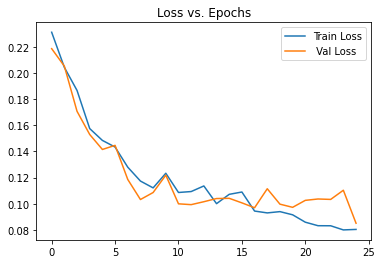

In [ ]:
plt.plot(train_loss_hist,label='Train Loss')
plt.plot(val_loss_hist,label=' Val Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# Prueba del algoritmo

In [ ]:
def unet_segmentation(I,model,nl=32,nc=32,show=0):
    J     = I.astype(float)
    (N,M) = J.shape
    jmax  = np.max(J)
    jmin  = np.min(J)
    J     = (J-jmin)/(jmax-jmin)
    QX    = cv2.resize(J,(nc,nl))
    qx    = np.float32(QX)
    qx    = qx.reshape(1,nl,nc,1)
    qx    = np.swapaxes(qx, 1, 3)
    qx    = np.swapaxes(qx, 2, 3)

    qx    = torch.from_numpy(qx).to(device)
    model.eval()
    qp    = model(qx)
    qp    = qp.cpu().detach().numpy()
    qp    = qp.reshape(nl,nc)
    QPB   = np.zeros((nl,nc),dtype='uint8')
    QPB[ qp>=0.5 ] = 255

    if show:
        f = plt.figure()
        f.add_subplot(1,2,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
        f.add_subplot(1,2,2); plt.imshow(QPB,cmap="gray"); plt.axis('off')
        plt.show(block=True)

    R = cv2.resize(QPB,(M,N))>128

    return R

# Performance: Precision / Recall

In [ ]:
TP = 0
FP = 0
FN = 0
for i in range(qx.shape[0]):
  X  = qx[i,0,:,:]
  GT = qy[i,0,:,:]
  D  = unet_segmentation(X, model, nl=n, nc=n)
  TP = TP + np.sum(np.multiply(D==1,GT==1))
  FP = FP + np.sum(np.multiply(D==1,GT==0))
  FN = FN + np.sum(np.multiply(D==0,GT==1))
Pr = TP/(TP+FP)
Re = TP/(TP+FN)

print('Testing:')
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')


Testing:
Precision = 0.8266
Recall    = 0.9261


# Ejemplo de segmentación de imagen de pruebas

processing file skin/color/ISIC_0031029_00.jpg


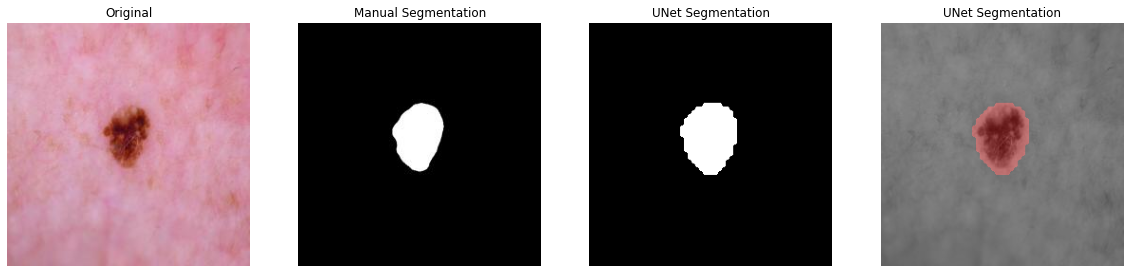

In [ ]:
i =  229 # <= Ingrese aqui imagen de testing
# Input: Color Image
st = img_names[i]
print('processing file '+st)
img0 = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)

# Manual Segmentation
xt = seg_names[i]
Ri = cv2.cvtColor(cv2.imread(xt), cv2.COLOR_BGR2RGB)

# UNet Segmentation
img   = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
R     = unet_segmentation(img, model,nl=n, nc=n)
imgs  = regionview(img,R)

# Output
f = plt.figure(figsize=(20,6))

f.add_subplot(1,4,1); plt.imshow(img0); plt.axis('off'); plt.title('Original')
f.add_subplot(1,4,2); plt.imshow(Ri); plt.axis('off'); plt.title('Manual Segmentation')
f.add_subplot(1,4,3); plt.imshow(R,cmap="gray"); plt.axis('off'); plt.title('UNet Segmentation')
f.add_subplot(1,4,4); plt.imshow(imgs); plt.axis('off'); plt.title('UNet Segmentation')
plt.show()


Segunda implementación de UNet (puede ser usada como alternativa a la primera implementación)

In [ ]:
class Unet(nn.Module):

    def __init__(self, n, batch_size=50):

        super().__init__()

        self.conv_1 = self.conv_layer(n, 0)
        self.conv_2 = self.conv_layer(n, 1)
        self.conv_3 = self.conv_layer(n, 2)
        self.conv_4 = self.conv_layer(n, 3)
        self.conv_5 = self.conv_layer(n, 4)
        self.conv_6 = self.conv_layer(n, 5)
        self.conv_7 = self.conv_layer(n, 6)
        self.conv_8 = self.conv_layer(n, 7)
        self.conv_9 = self.conv_layer(n, 8)

        self.conv_A = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=1, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.up_6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_7 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

    @staticmethod
    def conv_layer(n, l_n):
        if l_n == 0:
            in_  = 1
            out_ = n
        elif l_n < 5:
            in_  = int(n * (2 ** (l_n - 1)))
            out_ = int(n * (2 ** l_n))
        else:
            in_  = int(n * (2 ** (9 - l_n) ))
            out_ = int(n * (2 ** (9 - l_n - 1)))

        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=out_, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_, out_channels=out_, kernel_size=3, padding='same'),
            nn.ReLU(),
        )
        return conv


    def forward(self, input_):
        conv_1 = self.conv_1(input_)
        pool_1 = nn.MaxPool2d(kernel_size=(2,2))(conv_1)

        conv_2 = self.conv_2(pool_1)
        pool_2 = nn.MaxPool2d(kernel_size=(2,2))(conv_2)

        conv_3 = self.conv_3(pool_2)
        pool_3 = nn.MaxPool2d(kernel_size=(2,2))(conv_3)

        conv_4 = self.conv_4(pool_3)
        pool_4 = nn.MaxPool2d(kernel_size=(2,2))(conv_4)

        conv_5 = self.conv_5(pool_4)

        up_6    = self.up_6(conv_5)
        merge_6 = torch.cat([conv_4, up_6], dim=1)
        conv_6  = self.conv_6(merge_6)

        up_7    = self.up_7(conv_6)
        merge_7 = torch.cat([conv_3, up_7], dim=1)
        conv_7  = self.conv_7(merge_7)

        up_8    = self.up_8(conv_7)
        merge_8 = torch.cat([conv_2, up_8], dim=1)
        conv_8  = self.conv_8(merge_8)

        up_9    = self.up_9(conv_8)
        merge_9 = torch.cat([conv_1, up_9], dim=1)
        conv_9  = self.conv_9(merge_9)

        return self.conv_A(conv_9)